# 0.0. Helper Functions

In [38]:
# exploratory data analysis
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
# import matplotlib             as plt
import matplotlib.pyplot      as plt
import scikitplot             as skplt

# jupyter settings
from IPython.core.display     import HTML

# data extraction
import pandas.io.sql          as psql
import psycopg2               as pg

from sqlalchemy               import create_engine, text
from sqlalchemy_utils         import database_exists, create_database

# useless
# from postgre_credentials import *

# import xgboost as xgb
from sklearn.preprocessing   import MinMaxScaler
from sklearn.linear_model    import LogisticRegression
from category_encoders.count import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn                 import metrics as mt
from sklearn.neighbors       import KNeighborsClassifier
from category_encoders       import TargetEncoder
from sklearn.preprocessing   import RobustScaler
from sklearn.preprocessing   import StandardScaler

from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score, label_ranking_average_precision_score
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV

In [99]:
def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = username,
                          password = pwd,
                          host = host,
                          port = port,
                          database = database)
    return conn

def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 12
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def subplots_adjust():
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    return None


def metrics(y_test, y_predict,yhat_proba):

    accuracy_score  = mt.accuracy_score(y_test, y_predict)
    precision_score = mt.precision_score(y_test, y_predict, labels=1, zero_division=1)
    recall_score    = mt.recall_score(y_test, y_predict)
    f1_score        = mt.f1_score(y_test, y_predict)

    print(f'Acurácia: {accuracy_score}')
    print(f'Precisão: {precision_score}')
    print(f'Recall:   {recall_score}')
    print(f'F1 Score: {f1_score}')

    skplt.metrics.plot_cumulative_gain(y_test, yhat_proba)
    
    return None

def dataframe_metrics(X_test, y_test, yhat_proba, k=0.4):
    df_prob = X_test.copy()
    df_prob['response'] = y_test
    df_prob['prob_0'] = yhat_proba[:,0]
    df_prob['prob_1'] = yhat_proba[:,1]
    df_prob = df_prob.sort_values(by='prob_1', ascending=False)
    df_prob = df_prob.reset_index(drop=True)
    df_prob['1_at_k'] = df_prob['response'].cumsum()
    df_prob['recall_at_k'] = df_prob['1_at_k']/df_prob['response'].sum()
    df_prob['row'] = df_prob.index.values + 1
    df_prob['base_at_k'] = df_prob['row'] / len(df_prob)
    
    recall_at_k = df_prob.loc[ int(len(df_prob) * 0.4) , 'recall_at_k']
    
    print(f'O recall para {k*100}% da base é de: {recall_at_k:2f}')
    
    
    return None

def recall_at_k(X_test, y_test, yhat_proba, k=0.4):
    df_prob                = X_test.copy()
    df_prob['response']    = y_test
    df_prob['prob_0']      = yhat_proba[:,0]
    df_prob['prob_1']      = yhat_proba[:,1]
    df_prob                = df_prob.sort_values(by='prob_1', ascending=False)
    df_prob                = df_prob.reset_index(drop=True)
    df_prob['1_at_k']      = df_prob['response'].cumsum()
    df_prob['recall_at_k'] = df_prob['1_at_k']/df_prob['response'].sum()
    df_prob['row']         = df_prob.index.values + 1
    df_prob['base_at_k']   = df_prob['row'] / len(df_prob)
    
    recall_at_k = df_prob.loc[ int(len(df_prob) * k) , 'recall_at_k']
    
    return recall_at_k

# 1.0 Loading Data

## 1.1 Database - Credentials & Connector 

In [40]:
# # Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = '5432'
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

# # Connector
# conn = pg.connect( user=username,
#                    password=pwd,
#                    host=host,
#                    port=port,
#                    database=database)

## 1.2 Data Collection - Tables and Schema Query

In [41]:
# # psycopg_connect()

# engine = create_engine('postgresql://'+username+':'+pwd+'@'+host+':'+port+'/'+database+'')

# with engine.begin() as conn: 
#     #select tables from schema
#     query_tables = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
#     df_tables = pd.read_sql( text(query_tables) , conn )

#     # users
#     query_users = """SELECT * FROM pa004.users """
#     df_users = pd.read_sql( text(query_users) , conn )
    
#     # insurance
#     query_insurance = """SELECT * FROM pa004.insurance """
#     df_insurance = pd.read_sql( text(query_insurance) , conn )

#     # vehicle
#     query_vehicle = """SELECT * FROM pa004.vehicle """
#     df_vehicle = pd.read_sql( text(query_vehicle) , conn )

#     #build raw dataset:
#     query_raw = """
#     SELECT *
#     FROM pa004.users u 
#     INNER JOIN pa004.vehicle v on u.id = v.id 
#     INNER JOIN pa004.insurance i ON u.id = i.id
#     ORDER BY u.id
#     """
#     df_raw = pd.read_sql( text(query_raw) , conn )

## 1.3 Creating the main DataFrame - df_raw

In [42]:
# # creating df_raw
# df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
# df_raw.head()

In [43]:
# df_raw.to_csv('df_raw.csv', index=False)

In [44]:
df_raw = pd.read_csv('./dataset/df_raw.csv')

# 2.0 Data Description

In [45]:
df2 = df_raw.copy()

## 2.1 Rename Columns 

In [46]:
df2 = df2.rename(columns = {'vintage':'days_associated'})

## 2.2 Data Dimensions 

In [47]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 2.3 Data Types

In [48]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
days_associated           int64
response                  int64
dtype: object

## 2.4 Check NA

In [49]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
days_associated         0
response                0
dtype: int64

## 2.5 Fillout NA

In [50]:
# Não há nulos no dataset

## 2.6 Change types

In [51]:
# to object
df2['id'] = df2['id'].astype('object')

# to int
df2[['policy_sales_channel','region_code']] = df2[['policy_sales_channel','region_code']].astype('int64')

## 2.7 Descriptive Statistical

In [52]:
num_attributes = df2.select_dtypes( include= ['int64','float64'] )
cat_attributes = df2.select_dtypes( exclude= ['int64','float64', 'datetime64[ns]'] )

# Central Tendency - Mean, Median

ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()  ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew()  ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis()  ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-0.115266,-0.867857
2,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-0.900008,-0.970810
3,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-21.595182,464.354302
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,0.167747,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
6,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906,3.298788


# 3.0 Feature Engineering

In [53]:
df3 = df2.copy()

In [54]:
df3.sample(15)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
357774,357775,Male,26,35,152,1,< 1 Year,No,1,42243.0,142,0
135148,135149,Female,41,28,124,1,1-2 Year,Yes,0,32062.0,99,0
167740,167741,Male,61,41,4,1,1-2 Year,Yes,0,25837.0,246,1
270267,270268,Female,23,16,26,1,< 1 Year,Yes,0,37935.0,118,0
121166,121167,Female,37,15,163,1,1-2 Year,Yes,0,32903.0,16,1
270393,270394,Female,48,6,26,1,1-2 Year,No,1,28941.0,176,0
37589,37590,Male,41,28,56,1,1-2 Year,Yes,0,2630.0,175,0
5607,5608,Female,29,41,152,1,< 1 Year,No,1,39271.0,232,0
87856,87857,Male,22,10,152,1,< 1 Year,No,1,38765.0,127,0
23280,23281,Female,24,15,152,1,< 1 Year,No,1,27845.0,238,0


## 3.1 Mapa Mental de Hipóteses

## 3.2 Feature Engineering


In [55]:
# changing the categories in 'vehicle_age' column
vehicle_age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_years', '> 2 Years':'more_than_2_years'}
df3['vehicle_age'] = df3['vehicle_age'].map(vehicle_age_dict)

# 4.0 Filtragem de variáveis

In [56]:
# Rever a explicação do Meigarom sobre essa parte

In [57]:
df4 = df3.copy()

# 5.0 EDA - Exploratory Data Analysis

- Hipóteses sao mais propensas a adquirir o seguro saude:
- H1 - Mulheres
- H2 - Pessoas mais velhas 
- H3 - Pessoas com carros mais velhos 
- H4 - Pessoas com carros danificados 
- H5 - Pessoas previously_insured 
- H6 - Pessoas com maior 'annual_premium'
- H7 - Pessoas a mais tempos associadas

In [58]:
df5 = df4.copy()

## 5.1 Análise Univariada

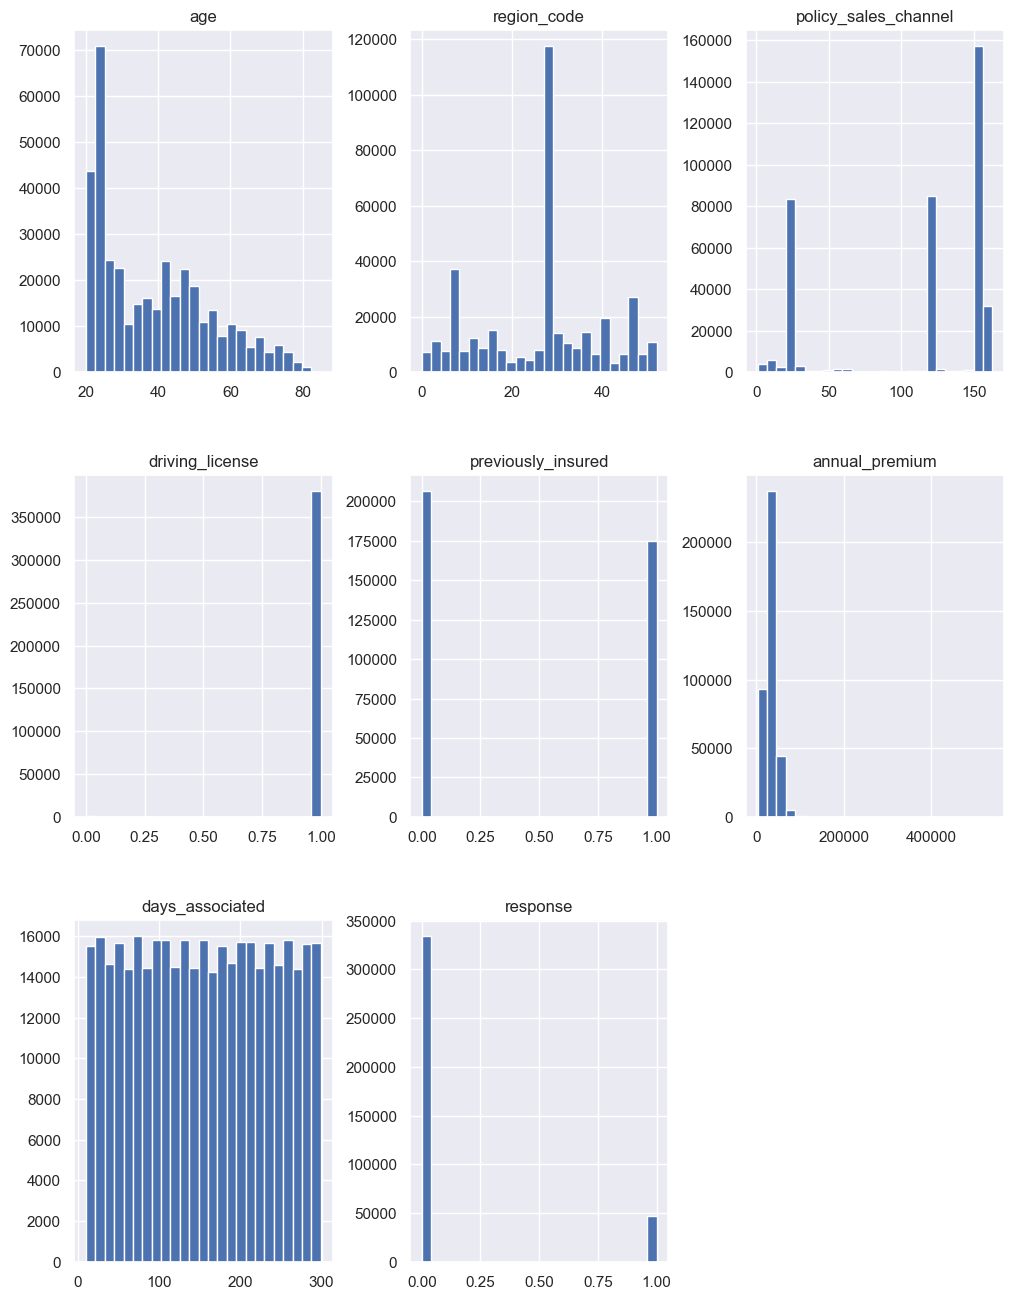

In [59]:
num_attributes.hist(bins=25, figsize=(12,16));

## 5.2 Análise Bivariada

### 5.1 - H1 - Mulheres sao mais propensas a adquirir o seguro saude

Falso. Homens são mais propensos que mulheres

In [60]:
aux = df5.loc[:, ['gender','response']].groupby(by=['gender']).agg({'gender':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']
aux

,gender,total,positive,percentual
0,Female,175020,18185,0.103902
1,Male,206089,28525,0.138411


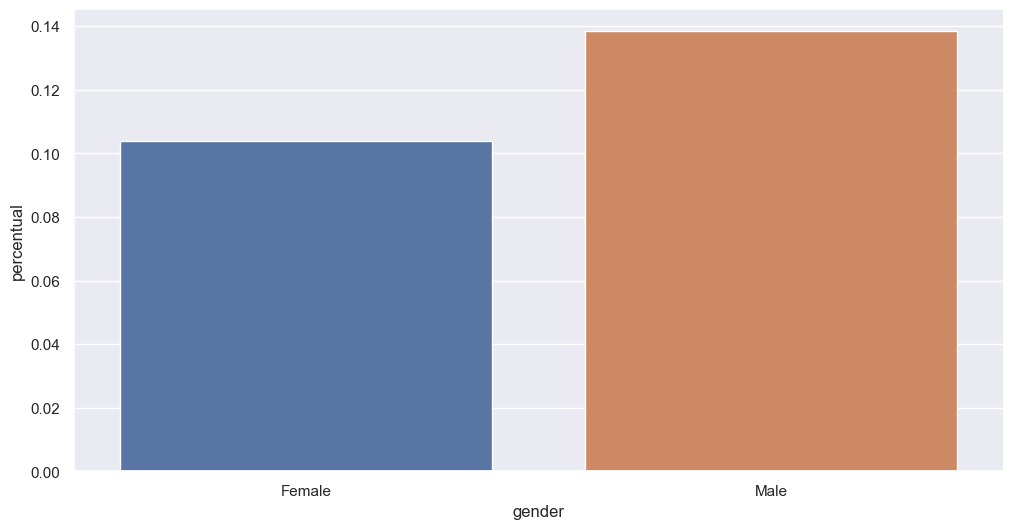

In [61]:
sns.barplot( x='gender',y='percentual', data = aux);

### 5.2 - H2 - Pessoas mais velhas sao mais propensas a adquirir o seguro saude

Falso. Pessoas de idade intermediaria são mais propensas a adquirir o seguro saude

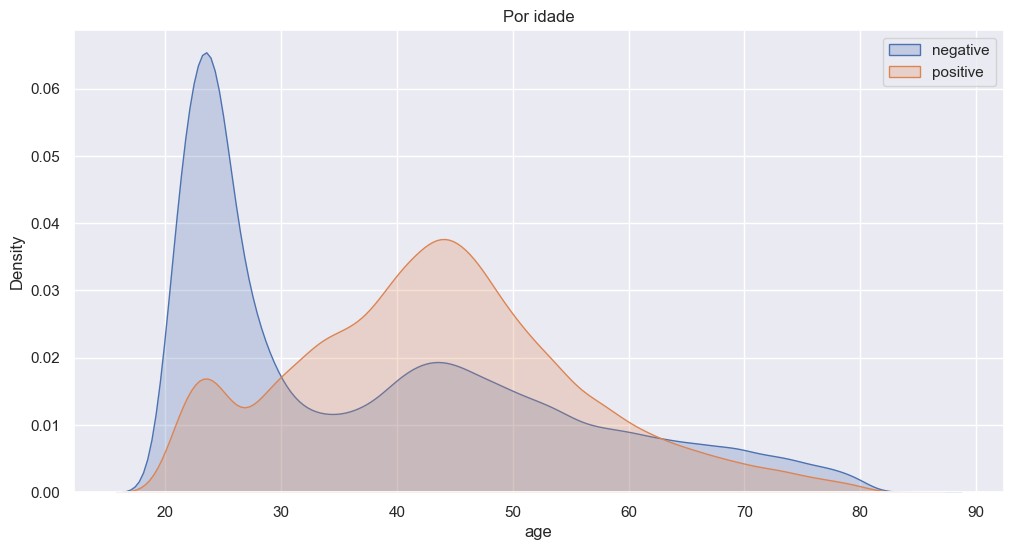

In [62]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0)
filter1 = (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Por idade');

### 5.3 - H3 - Pessoas com carros mais velhos sao mais propensas a adquirir o seguro saude

Verdadeiro. Quanto mais velho o carro, mais propenso de adquirir o seguro saude.

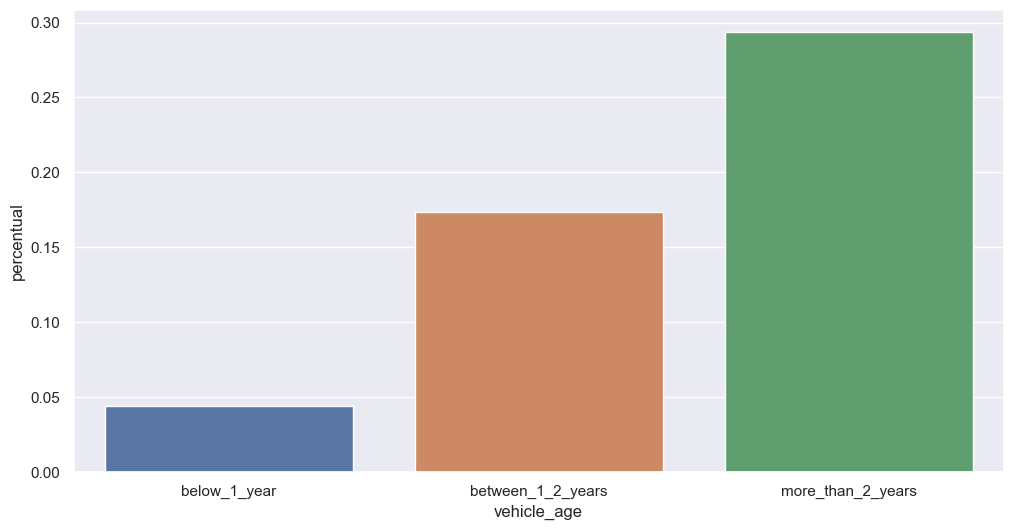

In [63]:
aux = df5.loc[:, ['vehicle_age','response']].groupby(by=['vehicle_age']).agg({'vehicle_age':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='vehicle_age', y='percentual');

### 5.4 - H4 - Pessoas com carros danificados sao mais propensas a adquirir o seguro saude

Verdadeiro. Pessoas com carros danificados são mais propensas a adquirir o seguro saúde

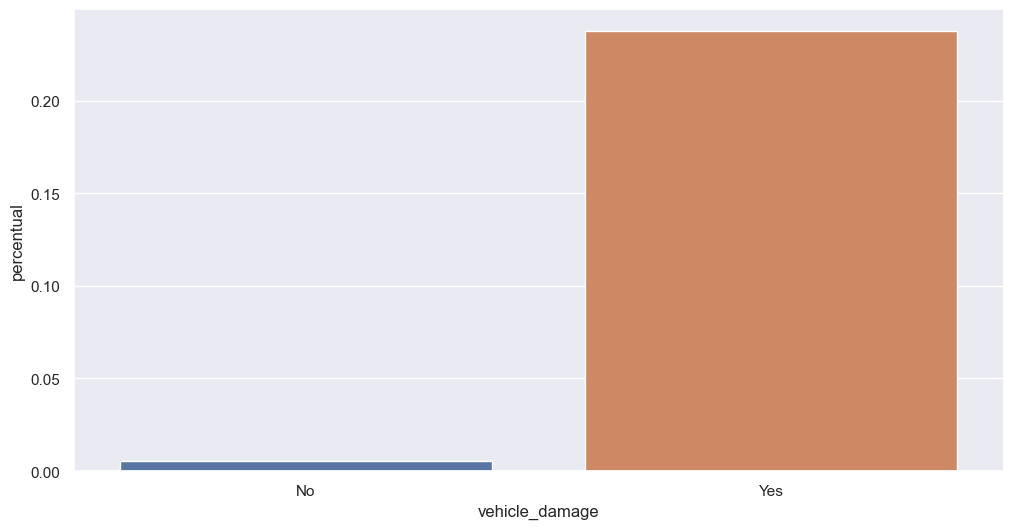

In [64]:
aux = df5.loc[:, ['vehicle_damage','response']].groupby(by=['vehicle_damage']).agg({'vehicle_damage':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='vehicle_damage', y='percentual');

In [65]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,Male,44,28,26,1,more_than_2_years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,No,0,33536.0,183,0
2,3,Male,47,28,26,1,more_than_2_years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,No,1,27496.0,39,0


### 5.5 - H5 - Pessoas previamente asseguradas sao mais propensas a adquirir o seguro saude

Falso. Pessoas nunca asseguradas são as mais propensas a adquirir o seguro saude

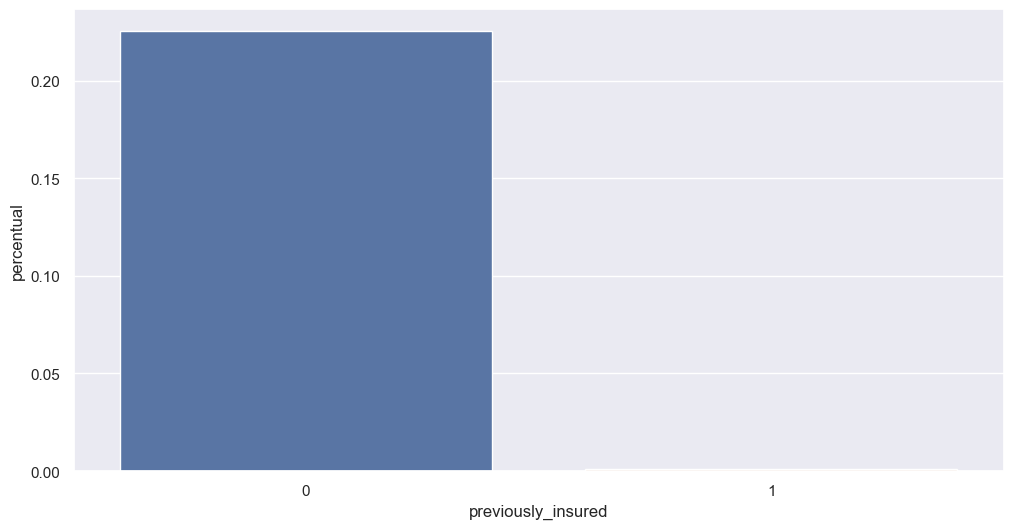

In [66]:
aux = df5.loc[:, ['previously_insured','response']].groupby(by=['previously_insured']).agg({'previously_insured':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='previously_insured', y='percentual');

### 5.6 - H6 - Pessoas que ganham mais sao mais propensas a adquirir o seguro saude

Falso. Cancela da mesma maneira

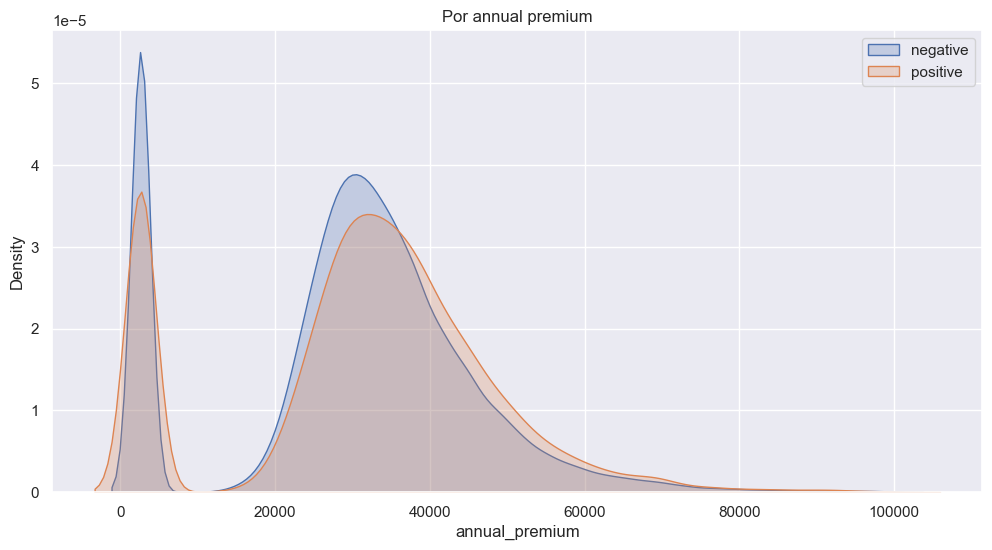

In [67]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0) & (df5['annual_premium'] < 100000)
filter1 = (df5['response'] == 1) & (df5['annual_premium'] < 100000)

sns.kdeplot( df5.loc[filter0, 'annual_premium'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'annual_premium'], label='positive', fill=True )
plt.legend()
plt.title('Por annual premium');

### 5.7 - H7 Pessoas a mais tempo associadas sao mais propensas a adquirir o seguro saude

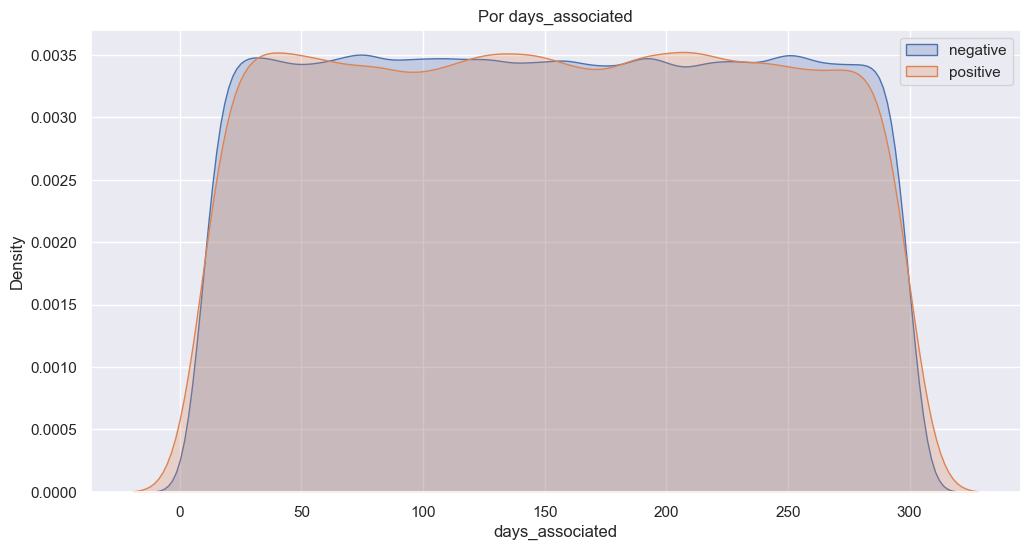

In [68]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0)
filter1 = (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'days_associated'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'days_associated'], label='positive', fill=True )
plt.legend()
plt.title('Por days_associated');

### 5.8 - H8 

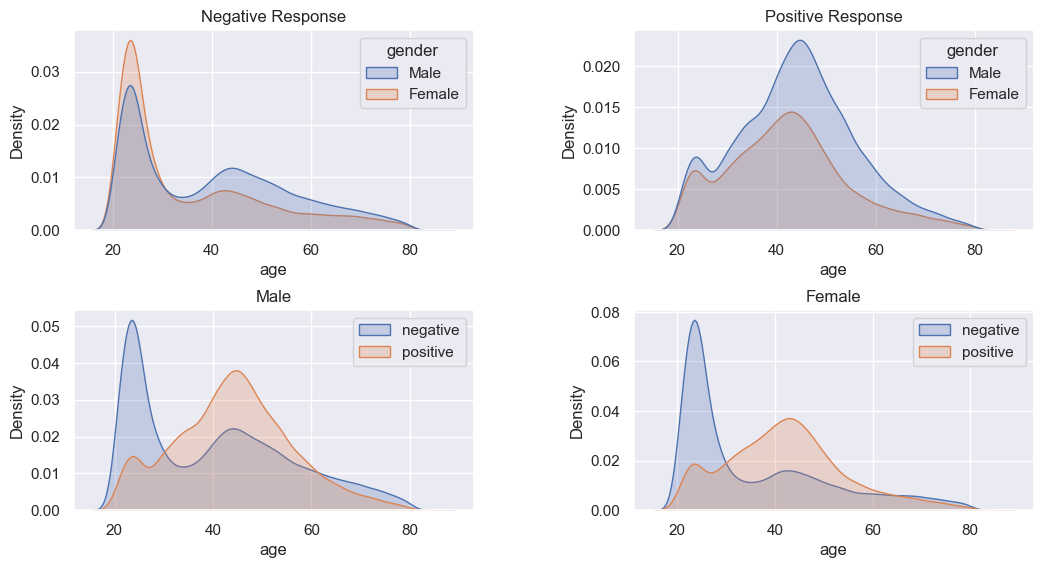

In [69]:
subplots_adjust()

plt.subplot(2,2,1)
sns.kdeplot( df5.loc[ df5['response'] == 0, ['gender', 'age']], x='age', hue='gender', fill=True, )
plt.title('Negative Response')

plt.subplot(2,2,2)
sns.kdeplot( df5.loc[ df5['response'] == 1, ['gender', 'age']], x='age', hue='gender', fill=True, )
plt.title('Positive Response')

plt.subplot(2,2,3)
filter0 = (df5['gender'] == 'Male') & (df5['response'] == 0)
filter1 = (df5['gender'] == 'Male') & (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Male')

plt.subplot(2,2,4)
filter0 = (df5['gender'] == 'Female') & (df5['response'] == 0)
filter1 = (df5['gender'] == 'Female') & (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Female');

## 5.3 Análise multivariada

### 5.3.1 Numerical Attributes


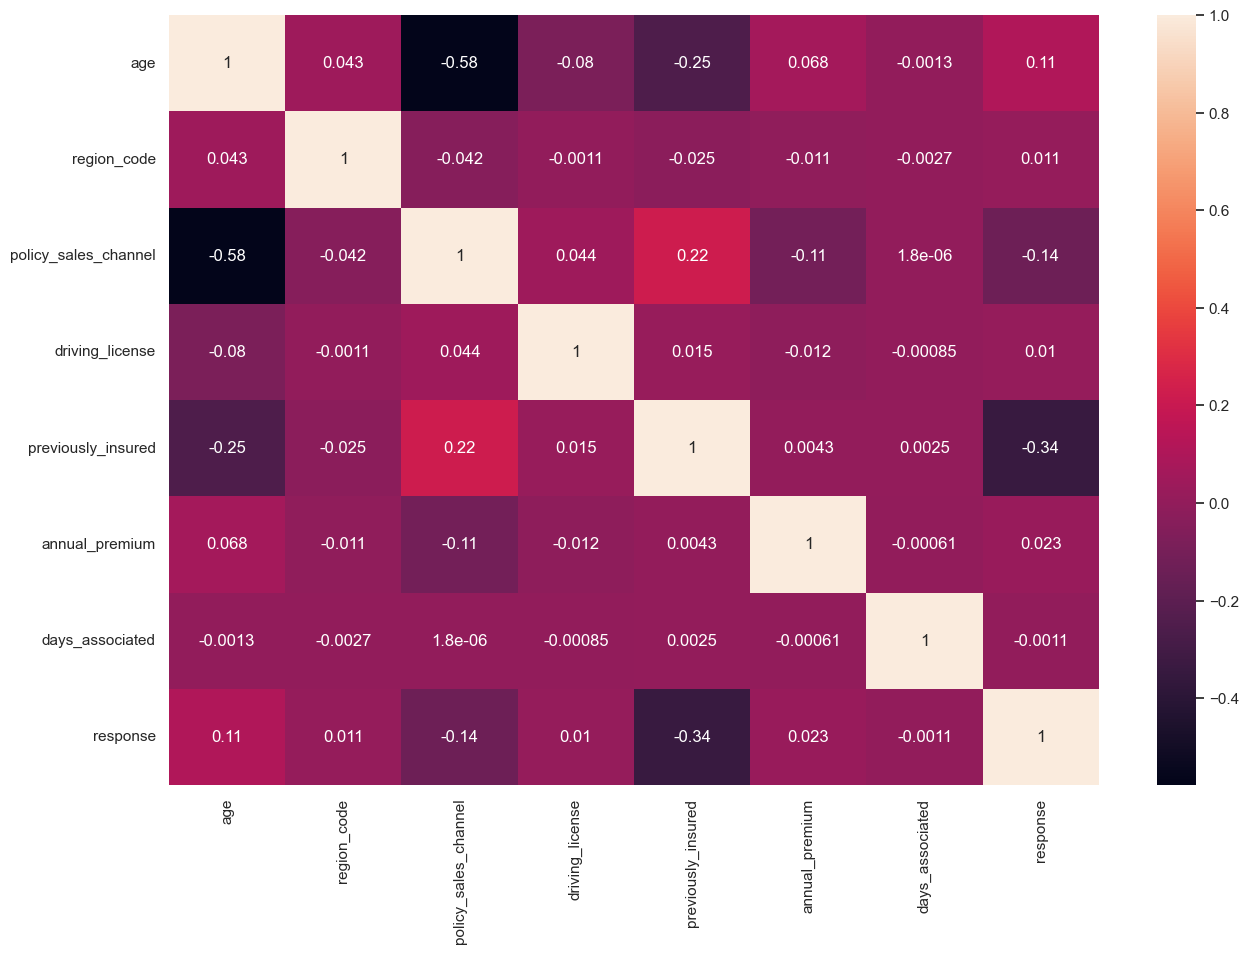

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 6.0 Data Preparation

In [71]:
df6 = df5.copy()

## 6.2 Transformação

In [72]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,Male,44,28,26,1,more_than_2_years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,No,0,33536.0,183,0
2,3,Male,47,28,26,1,more_than_2_years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,between_1_2_years,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,below_1_year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,below_1_year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,more_than_2_years,Yes,0,44617.0,74,0


In [73]:
# One Hot Encoding
df6['vehicle_damage'] = df6['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)
df6['gender'] = df6['gender'].apply(lambda x: 1 if x=='Male' else 0)

# Target Encoding
vehicle_age_encoding = {'below_1_year':1, 'between_1_2_years':2, 'more_than_2_years':3}
df6['vehicle_age'] = df6['vehicle_age'].map(vehicle_age_encoding)

region_code_encoding = df6.groupby('region_code')['response'].mean()
df6['region_code'] = df6['region_code'].map(region_code_encoding)

policy_sales_channel_encoding = df6.groupby('policy_sales_channel')['response'].mean()
df6['policy_sales_channel'] = df6['policy_sales_channel'].map(policy_sales_channel_encoding)

In [74]:
# mms = MinMaxScaler()

# df6['annual_premium']       = mms.fit_transform(df6[['annual_premium']].values)
# df6['days_associated']      = mms.fit_transform(df6[['days_associated']].values)
# df6['age']                  = mms.fit_transform(df6[['age']].values)
# df6['policy_sales_channel'] = mms.fit_transform(df6[['policy_sales_channel']].values)
# df6['region_code']          = mms.fit_transform(df6[['region_code']].values)

In [75]:
ss = StandardScaler()

df6['annual_premium']       = ss.fit_transform(df6[['annual_premium']].values)
df6['days_associated']      = ss.fit_transform(df6[['days_associated']].values)
df6['age']                  = ss.fit_transform(df6[['age']].values)
df6['policy_sales_channel'] = ss.fit_transform(df6[['policy_sales_channel']].values)
df6['region_code']          = ss.fit_transform(df6[['region_code']].values)

In [76]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,1,0.333777,1.426484,0.889268,1,3,1,0,0.574539,0.748795,1
1,2,1,2.396751,0.112584,0.889268,1,2,0,0,0.172636,0.342443,0
2,3,1,0.527181,1.426484,0.889268,1,3,1,0,0.449053,-1.521998,1
3,4,1,-1.148985,-0.216476,-1.087420,1,1,0,1,-0.113018,0.581474,0
4,5,0,-0.633242,-0.017380,-1.087420,1,1,0,1,-0.178259,-1.378580,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,2.267815,-1.110246,0.889268,1,2,0,1,-0.022912,-0.792954,0
381105,381106,1,-0.568774,-0.956251,-1.087420,1,1,0,1,0.549093,-0.279037,0
381106,381107,1,-1.148985,-1.076230,-1.166292,1,1,0,1,0.264543,0.079509,0
381107,381108,0,1.881007,-0.714430,0.770764,1,3,1,0,0.816389,-0.960275,0


# 7.0 Feature Selection

In [77]:
df7 = df6.copy()

# 8.0. Machine Learning Model

## 8.1. Linear Regression

Acurácia: 0.8760889187430466
Precisão: 0.39487179487179486
Recall:   0.006544836379090523
F1 Score: 0.012876254180602006


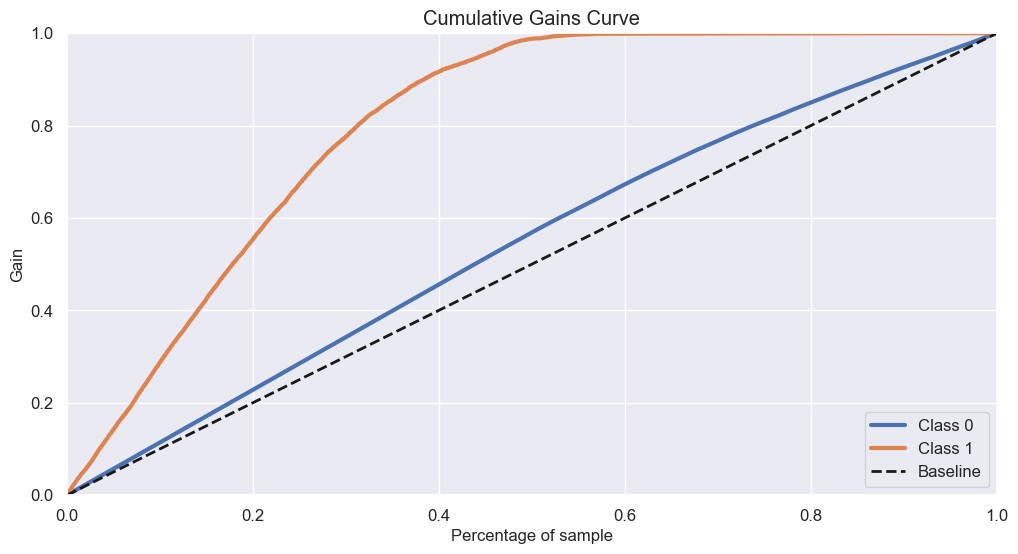

In [97]:
df8 = df6.copy()
X = df8.drop(columns=['id','response','gender','driving_license'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

In [79]:
# dataframe_metrics(X_test, y_test, yhat_proba, k=0.4)

In [80]:
# # Registrando os resultados

# lr_results = {'model':['LinearRegression'], 'k': [0.4], 'recall_at_k': [0.916447]}
# df_lr = pd.DataFrame(lr_results)

In [109]:
max_iter = [100, 1000, 10000]
C = [0.1, 1.0, 10.0, 20.0]
solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for i in range(0,5):
    df8 = df6.copy()
    X = df8.drop(columns=['id','response','gender','driving_license'])
    y = df8['response']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    lr = LogisticRegression( max_iter=random.choice(max_iter), C=random.choice(C), solver=random.choice(solver) )

    lr.fit(X_train, y_train)

    y_predict = lr.predict( X_test )
    yhat_proba = lr.predict_proba( X_test )

    x = recall_at_k(X_test, y_test, yhat_proba, k=0.4)
    print(x)

0.9164470888227795
0.9164470888227795
0.9164470888227795
0.9164470888227795
0.9166170845728857


In [98]:
recall_at_k(X_test, y_test, yhat_proba, k=0.4)

TypeError: 'numpy.float64' object is not callable

In [152]:
df8 = df6.copy()
X = df8.drop(columns=['id','response','gender','driving_license'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=20, C=10 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

x = recall_at_k(X_test, y_test, yhat_proba, k=0.4)
x

C:\Users\leonardorose\anaconda3\envs\pa04\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9167870803229919

## 8.2. XGBoost Classifier

In [178]:
import xgboost as xgb

In [278]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100)
xgb_model.fit(X_train, y_train)

y_predict_xgb = xgb_model.predict( X_test )
yhat_proba_xgb = xgb_model.predict_proba(X_test)

Acurácia: 0.8765612208484644
Precisão: 0.5044642857142857
Recall:   0.01920951976200595
F1 Score: 0.037009743715712765


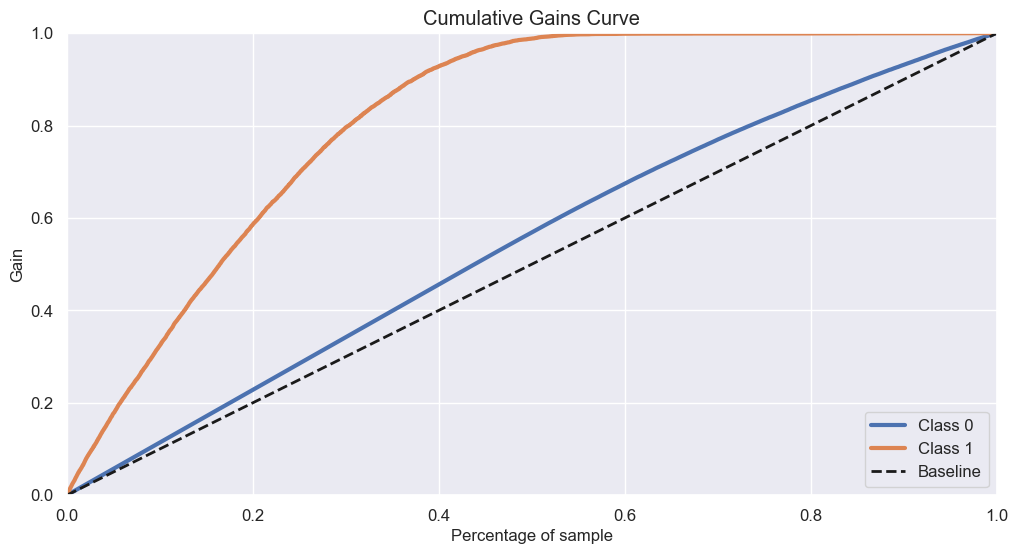

In [279]:
metrics(y_test,y_predict_xgb, yhat_proba_xgb)

In [280]:
dataframe_metrics(X_test, y_test, yhat_proba_xgb, k=0.4)

O recall para 40.0% da base é de: 0.928347


In [281]:
xgb_recall_at_k = recall_at_k(X_test, y_test, yhat_proba_xgb, k=0.4)
xgb_recall_at_k

0.9283467913302167

In [282]:
# Registrando os resultados
xgb_results = {'model':['XGBoost'], 'k': [0.4], 'recall_at_k': [0.928347]}
df_xgb = pd.DataFrame(xgb_results)

## 8.3. Gradient Boosting Classifier

In [250]:
from sklearn.ensemble import GradientBoostingClassifier

In [289]:
gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbrt.fit(X_train, y_train)

y_predict_gbc  = gbrt.predict(X_test)
yhat_proba_gbc = gbrt.predict_proba(X_test)

Acurácia: 0.8765192384390941
Precisão: 1.0
Recall:   0.0
F1 Score: 0.0


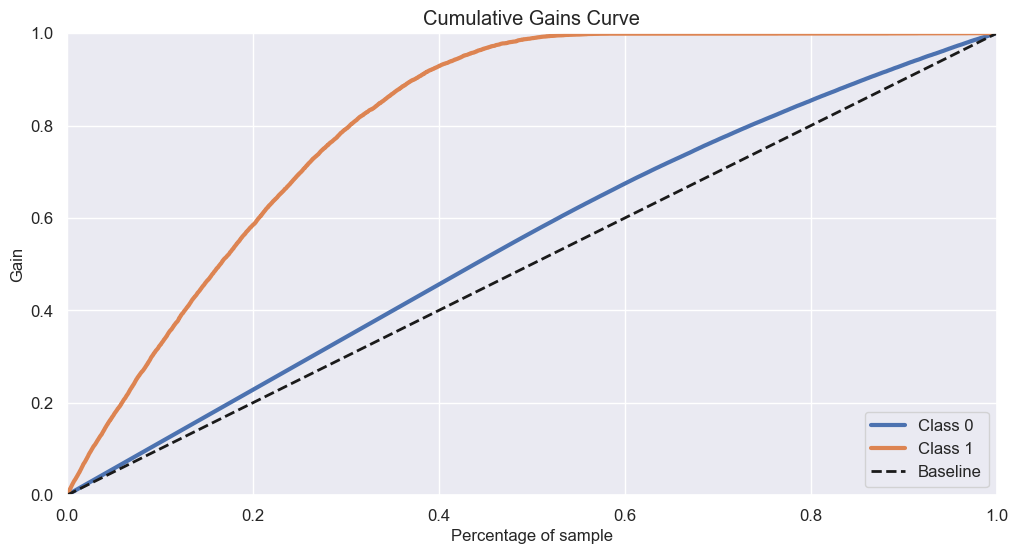

In [290]:
metrics(y_test,y_predict_gbc, yhat_proba_gbc)

In [291]:
gbrt_recall_at_k = recall_at_k(X_test, y_test, yhat_proba_gbc, k=0.4)
gbrt_recall_at_k

0.9286017849553762

In [300]:
# Registrando os resultados
gbcr_results = {'model':['GradientBoostingClassifier'], 'k': [0.4], 'recall_at_k': [0.9286017849553762]}
df_gbcr = pd.DataFrame(gbcr_results)

## 8.4. KNN

In [295]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=75)
knn.fit(X_train, y_train)

y_predict_knn  = knn.predict(X_test)
yhat_proba_knn = knn.predict_proba(X_test)


Acurácia: 0.8761413967547598
Precisão: 0.44857142857142857
Recall:   0.013344666383340417
F1 Score: 0.025918283120099053


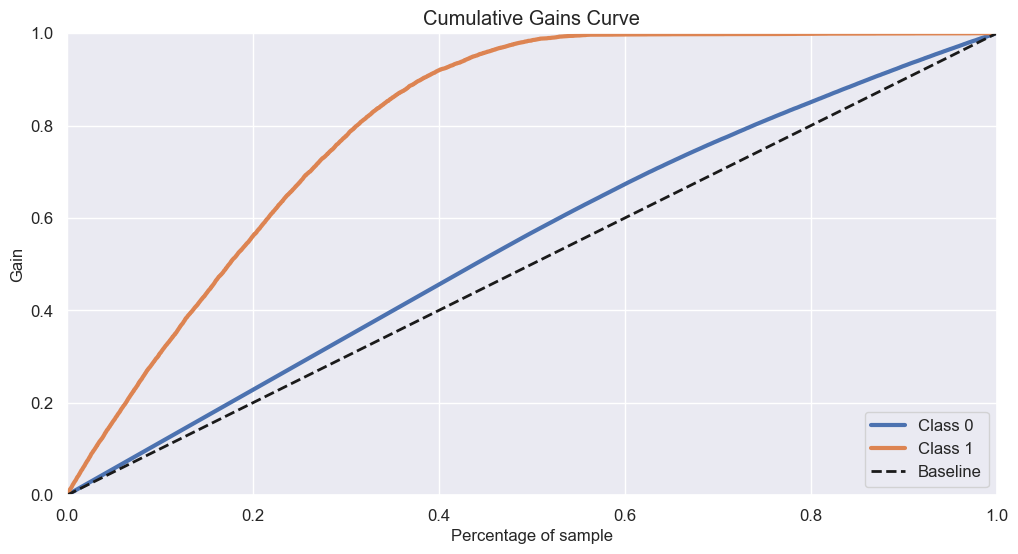

In [296]:
metrics(y_test,y_predict_knn, yhat_proba_knn)

In [297]:
knn_recall_at_k = recall_at_k(X_test, y_test, yhat_proba_knn, k=0.4)
knn_recall_at_k

0.9199320016999575

In [301]:
# Registrando os resultados
knn_results = {'model':['KNN'], 'k': [0.4], 'recall_at_k': [0.9199320016999575]}
df_knn = pd.DataFrame(knn_results)
df_knn

,model,k,recall_at_k
0,KNN,0.4,0.919932


In [6]:
import random

In [36]:
lista = [0,1,2,3,4,5,6,7,8,9,10]
random.choice(lista)

8

## 8.x. Comparing Models

In [302]:
models_results = pd.concat([df_xgb, df_lr,df_gbcr,df_knn], axis=0)
models_results

,model,k,recall_at_k
0,XGBoost,0.4,0.928347
0,LinearRegression,0.4,0.916447
0,GradientBoostingClassifier,0.4,0.928602
0,KNN,0.4,0.919932


# 9.0 Deployment

In [54]:
class HealthInsurance:
    def __init__( self ):
        self.home_path=''
        self.home=''
        
    def data_cleaning( df2 ):
    
    df2 = df2.rename(columns = {'vintage':'days_associated'})
    
    return df2

    def feature_engineering( df3 ):
        # changing the categories in 'vehicle_age' column
        vehicle_age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_years', '> 2 Years':'more_than_2_years'}
        df3['vehicle_age'] = df3['vehicle_age'].map(vehicle_age_dict)
        
        return df3

    def data_preparation( df4 ):
        # One Hot Encoding
        df6['vehicle_damage'] = df6['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)
        df6['gender'] = df6['gender'].apply(lambda x: 1 if x=='Male' else 0)

        # Target Encoding
        vehicle_age_encoding = {'below_1_year':1, 'between_1_2_years':2, 'more_than_2_years':3}
        df6['vehicle_age'] = df6['vehicle_age'].map(vehicle_age_encoding)

        region_code_encoding = df6.groupby('region_code')['response'].mean()
        df6['region_code'] = df6['region_code'].map(region_code_encoding)

        policy_sales_channel_encoding = df6.groupby('policy_sales_channel')['response'].mean()
        df6['policy_sales_channel'] = df6['policy_sales_channel'].map(policy_sales_channel_encoding) 

        return df4

IndentationError: expected an indented block after function definition on line 6 (2325241986.py, line 8)